<a href="https://colab.research.google.com/github/kuds/rl-drone/blob/main/%5BMultiple%20Targets%5D%20Soft%20Actor-Critic%20(SAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Random Point] Soft Actor-Critic (SAC)


In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install robot_descriptions
!pip install gymnasium
!pip install stable-baselines3

In [3]:
import gymnasium
import mujoco
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import VecNormalize
import numpy
import os
import csv
import torch
import pandas
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot
from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box
import robot_descriptions
from robot_descriptions import cf2_mj_description

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Robot Description Version: {version('robot_descriptions')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Mujoco Version: {version('mujoco')}")
print(f"Stable-Baselines3 Version: {version('stable-baselines3')}")
print(f"Matplotlib Version: {version('matplotlib')}")

Python Version: 3.12.11
Torch Version: 2.8.0+cu126
Is Cuda Available: True
Cuda Version: 12.6
Gymnasium Version: 1.2.0
Robot Description Version: 1.20.0
Numpy Version: 2.0.2
Mujoco Version: 3.3.5
Stable-Baselines3 Version: 2.7.0
Matplotlib Version: 3.10.0


In [5]:
rl_type = "SAC"
env_str = "BitCrazy"
log_dir = "./logs/{}".format(env_str)
name_prefix = "bit_crazy"

In [6]:
hyperparams = {
    "env_str": env_str,
    "rl_type": rl_type,
    "eval_freq": 25_000,
    "n_envs": 4,
    "total_timesteps": 1_500_000,
    "log_dir": log_dir,
    "episode_length": 2_500,
    "sphere_size": 0.1
}

In [7]:
csv_header = ["step",
              "drone_pos_x",
              "drone_pos_y",
              "drone_pos_z",
              "reward",
              "reward_normalized",
              "total_reward",
              "touch_reported",
              "sensor_reading",
              "made_contact",
              "distance_to_target",
              "done"]

In [8]:
class VideoRecordCallback(BaseCallback):
    def __init__(
        self,
        save_path: str,
        video_length: int,
        save_freq: int = 5_000,
        name_prefix: str ="rl_model",
        verbose: int = 0):

        super().__init__(verbose)
        self.save_freq = save_freq
        self.video_length = video_length
        self.save_path = save_path
        self.name_prefix = name_prefix
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:

          name_prefix = f"{self.name_prefix}_{self.num_timesteps}"

          # Record video of the best model playing
          rec_val = make_vec_env(make_env, n_envs=1)
          rec_val = VecNormalize(rec_val,
                                 training=False,
                                 norm_obs=True,
                                 norm_reward=True)
          rec_val = VecVideoRecorder(rec_val,
                                    self.save_path,
                                    video_length=self.video_length,
                                    record_video_trigger=lambda x: x == 0,
                                    name_prefix=name_prefix)

          obs = rec_val.reset()
          session_length = 0
          total_reward = 0.0
          total_contacts = 0.0
          csv_file_name = os.path.join(self.save_path, f"{name_prefix}.csv")
          with open(csv_file_name, 'w') as csvfile:
            csv_writer = csv.writer(csvfile, delimiter=',')
            csv_writer.writerow(csv_header)
            for _ in range(self.video_length):
              action, _states = self.model.predict(obs)
              obs_norm, rewards_norm, done, info = rec_val.step(action)
              obs = rec_val.get_original_obs()
              rewards = rec_val.get_original_reward()
              total_reward += rewards
              total_contacts += info[0]["made_contact"]
              #print(obs)
              row_data = numpy.concatenate([[int(session_length),
                                             obs[0][0],
                                             obs[0][1],
                                             obs[0][2],
                                             rewards[0],
                                             rewards_norm[0],
                                             total_reward[0],
                                             info[0]["touch_reported"],
                                             info[0]["sensor_reading"],
                                             info[0]["made_contact"],
                                             info[0]["distance_to_target"],
                                             done[0]]])
              row_data = numpy.round(row_data, decimals=4)
              csv_writer.writerow(row_data)
              rec_val.render()
              session_length += 1
              if done:
                break

          print(f"Step: {self.num_timesteps} | Session Length: {session_length} | Total Reward: {int(total_reward[0])} | Total Contacts: {int(total_contacts)}")

          rec_val.close()
        return True


In [9]:
import xml.etree.ElementTree as ET

# --- Configuration ---
# The script will modify this file directly
filename = cf2_mj_description.MJCF_PATH

# 1. Parse the existing XML file
try:
    tree = ET.parse(filename)
    root = tree.getroot()
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
    exit()
except ET.ParseError:
    print(f"Error: The file '{filename}' is not a valid XML file.")
    exit()

# 2. Find both the <worldbody> and <sensor> parent nodes
worldbody_node = root.find('worldbody')
sensor_node = root.find('sensor')

# 3. Validate that both parent nodes were found
if worldbody_node is not None and sensor_node is not None:
    changes_made = False
    print("Found <worldbody> and <sensor> nodes. Checking for elements...")

    # --- Action 1: Check for and add the fly_zone ---
    # The XPath "./body[@name='fly_zone']" finds a body element with a specific name
    if worldbody_node.find("./site[@name='fly_sensor']") is None:
        print(" -> Body 'fly_zone' not found. Adding it...")
        site_attributes = {
            'name': 'fly_sensor',
            'pos': '0 0 1',
            'size': str(hyperparams["sphere_size"]),
            'type': 'sphere',
            'rgba': '0 1 0 .25'
        }
        # ET.SubElement(ET.Element('site', attrib=site_attributes))
        ET.SubElement(worldbody_node, 'site', attrib=site_attributes)
        changes_made = True
    else:
        print(" -> Body 'fly_zone' already exists. Skipping.")

    # --- Action 2: Check for and add the touch_sensor ---
    if sensor_node.find("./touch[@name='touch_sensor']") is None:
        print(" -> Sensor 'touch_sensor' not found. Adding it...")
        touch_attributes = {'name': 'touch_sensor', 'site': 'fly_sensor'}
        ET.SubElement(sensor_node, 'touch', attrib=touch_attributes)
        changes_made = True
    else:
        print(" -> Sensor 'touch_sensor' already exists. Skipping.")

    # 4. Write to the file ONLY if changes were made
    if changes_made:
        ET.indent(tree, space="  ", level=0)
        tree.write(filename, encoding='utf-8', xml_declaration=True)
        print(f"\n✅ Successfully applied updates to '{filename}'.")
    else:
        print(f"\n✅ No updates needed. All elements already exist in '{filename}'.")

else:
    # This block runs if one or both parent nodes are missing
    print("❌ Error: Could not find both <worldbody> and <sensor> nodes. No changes were made.")
    if worldbody_node is None:
        print(" -> Missing <worldbody> node.")
    if sensor_node is None:
        print(" -> Missing <sensor> node.")

Found <worldbody> and <sensor> nodes. Checking for elements...
 -> Body 'fly_zone' already exists. Skipping.
 -> Sensor 'touch_sensor' already exists. Skipping.

✅ No updates needed. All elements already exist in '/root/.cache/robot_descriptions/mujoco_menagerie/bitcraze_crazyflie_2/cf2.xml'.


In [10]:
def modified_tanh(x):
    """
    Calculates the modified tanh function.
    """
    k = 5.406
    x0 = 0.575
    return 0.5 * (1 - numpy.tanh(k * (x - x0)))

def modified_tanh_final(x, factor=0.5):
    """
    Calculates the final modified tanh function.
    """
    k = 2.941
    x0 = 1.1
    return 0.5 * (1 - numpy.tanh(k * (x - x0)))

In [11]:
import gymnasium as gym
import numpy as np
import mujoco
import xml.etree.ElementTree as ET
from gymnasium.spaces import Box

# Import the path to the CF2 model from the library
from robot_descriptions.cf2_mj_description import MJCF_PATH as CF2_PATH

class DroneHoverEnv(MujocoEnv):
    """
    Custom Gymnasium environment for the drone hovering task.
    This version loads the drone model from `robot_descriptions`
    and programmatically builds the training scene.
    """

    metadata = {
    "render_modes": [
        "human",
        "rgb_array",
        "depth_array",
    ],
        "render_fps": 100,
    }

    def __init__(self, sphere_size=0.2, episode_len=1_000, frame_skip=5, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)

        self.model_path = os.path.join(cf2_mj_description.PACKAGE_PATH, "scene.xml")
        self.total_reward = 0

        # --- 3. Define Spaces and Target (same as before) ---
        self.action_space = Box(
            low=np.array([0.0, -1.0, -1.0, -1.0]),
            high=np.array([0.35, 1.0, 1.0, 1.0]),
            dtype=np.float64
        )

        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(19,), dtype=np.float64
        )

        # change shape of observation to your observation space size
        # load your MJCF model with env and choose frames count between actions
        MujocoEnv.__init__(
            self,
            self.model_path,
            frame_skip=5,
            observation_space=self.observation_space,
            **kwargs
        )

        self.noise_magnitude = 0.25
        self.step_number = 0
        self.sphere_size = sphere_size
        self.episode_len = episode_len
        self.frame_skip = frame_skip
        self.target_pos_id = self.model.site("fly_sensor").id
        self.target_pos = self.model.site_pos[self.target_pos_id]
        self.drone_body_id = self.model.body('cf2').id
        self.gyro_sensor_id = self.model.sensor('body_gyro').id
        self.fly_sensor_id = self.model.sensor('touch_sensor').id
        self.original_site_pos = self.model.site_pos[self.target_pos_id].copy()
        self.total_contacts = 0

    def _randomize_fly_zone(self):
        original_site_pos = self.model.site_pos[self.target_pos_id].copy()
        noise = self.noise_magnitude * numpy.random.randn(3)
        self.model.site_pos[self.target_pos_id] = original_site_pos + noise
        self.model.site_pos[self.target_pos_id][2] = max(0.5, self.model.site_pos[self.target_pos_id][2])
        self.target_pos = self.model.site_pos[self.target_pos_id]

    def _get_obs(self):
        """Constructs the observation vector from the simulation data."""
        drone_pos = self.data.qpos[:3]
        drone_quat = self.data.qpos[3:7]
        drone_lin_vel = self.data.qvel[:3]
        drone_ang_vel = self.data.sensor(self.gyro_sensor_id).data
        vec_to_target = self.target_pos - drone_pos

        return np.concatenate([
            drone_pos,
            drone_quat,
            vec_to_target,
            drone_lin_vel,
            drone_ang_vel,
            self.target_pos
        ]).astype(np.float64)

    def step(self, action):
        """Applies an action, steps the simulation, and calculates the reward."""
        self.data.ctrl[:] = action
        for _ in range(self.frame_skip):
            mujoco.mj_step(self.model, self.data)

        self.step_number += 1
        drone_pos = self.data.qpos[:3]
        distance_to_target = np.linalg.norm(drone_pos - self.target_pos)
        reward = modified_tanh_final(distance_to_target)

        #reward = -distance_to_target
        #reward -= 0.01 * np.square(action).sum()

        # Check for contact with the 'touch_sensor' site

        # Read the sensor value
        made_contact = 0
        touch_reported = False
        # print(self.data.sensor(self.fly_sensor_id).data)
        sensor_reading = self.data.sensor(self.fly_sensor_id).data[0]

        # A positive value means the sensor is being touched
        if (sensor_reading > 0 and not touch_reported):
            # print(f"Drone touched the sensor! | Senor Force {sensor_reading:.3f} | Distance: {distance_to_target:.3f}")
            touch_reported = True
            reward = 20.0 # Add a positive reward for touching the sensor
        elif distance_to_target <= self.sphere_size:
            made_contact = 1
            reward = 20.0 # Add a positive reward for touching the sensor

            self._randomize_fly_zone()
            # print(f"Target Position Moved! | New Location: {self.target_pos}")

        truncated = False
        terminated = False
        if bool(distance_to_target > 4.0 or drone_pos[2] < 0.025):
            reward = -10.0
            terminated = True
        elif self.step_number > self.episode_len:
            truncated = True

        self.total_reward += reward

        observation = self._get_obs()

        info = {'distance_to_target': distance_to_target,
                "touch_reported": touch_reported,
                "sensor_reading": sensor_reading,
                "made_contact": made_contact}

        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state."""
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        noise = self.np_random.uniform(low=-0.1, high=0.1, size=3)
        self.data.qpos[:3] += noise

        # Make sure that the drone doesn't start too low
        self.data.qpos[2] = max(0.075, self.data.qpos[2])
        self.model.site_pos[self.target_pos_id] = self.original_site_pos.copy()
        self.target_pos = self.model.site_pos[self.target_pos_id]
        self.total_contacts = 0
        self.step_number = 0
        self.total_reward = 0
        return self._get_obs(), {}

    # define what should happen when the model is reset (at the beginning of each episode)
    def reset_model(self, seed=None):
        self.step_number = 0
        self.total_reward = 0

        # for example, noise is added to positions and velocities
        qpos = self.init_qpos + self.np_random.uniform(
            size=self.model.nq, low=-0.01, high=0.01
        )

        # Make sure that the drone doesn't start too low
        qpos[2] =  max(0.075, qpos[2])

        qvel = self.init_qvel + self.np_random.uniform(
            size=self.model.nv, low=-0.01, high=0.01
        )
        self.set_state(qpos, qvel)
        return self._get_obs()

In [12]:
env = DroneHoverEnv()
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (19,)
Actions Space:  Box([ 0. -1. -1. -1.], [0.35 1.   1.   1.  ], (4,), float32)


In [13]:
def make_env():
  env = DroneHoverEnv(sphere_size=hyperparams["sphere_size"],
                      episode_len=hyperparams["episode_length"],
                      render_mode="rgb_array")
  check_env(env)
  return env

In [14]:
# Create Training environment
env = make_vec_env(make_env,
                   n_envs=hyperparams["n_envs"],
                   monitor_dir=os.path.join(log_dir, "monitor"))

normalized_env = VecNormalize(env,
                              training=True,
                              norm_obs=True,
                              norm_reward=True)


# Create Evaluation environment
env_val = make_vec_env(make_env, n_envs=1)
normalized_env_val = VecNormalize(env_val,
                                  training=False,
                                  norm_obs=True,
                                  norm_reward=True)


eval_callback = EvalCallback(normalized_env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20,
                             eval_freq=hyperparams["eval_freq"])

video_record_callback = VideoRecordCallback(
    save_path=os.path.join(log_dir, "videos"),
    video_length=10_000,
    save_freq=hyperparams["eval_freq"],
    name_prefix=name_prefix)

# Create the callback list
callbackList = CallbackList([eval_callback])
# callbackList = CallbackList([video_record_callback, eval_callback])

# learning with tensorboard logging and saving model
model = SAC("MlpPolicy",
            normalized_env,
            verbose=0,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

model.learn(total_timesteps=hyperparams["total_timesteps"],
            callback=callbackList,
            progress_bar=True)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model,
                                          normalized_env_val,
                                          deterministic=True,
                                          n_eval_episodes=20)
print(f"Final Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

normalized_env.save(os.path.join(log_dir, "normalized_env"))
normalized_env_val.save(os.path.join(log_dir, "normalized_env_val"))

env.close()
env_val.close()
normalized_env.close()
normalized_env_val.close()

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=100000, episode_reward=227.59 +/- 22.09

Episode length: 456.00 +/- 66.04

New best mean reward!

Eval num_timesteps=200000, episode_reward=198.50 +/- 58.72

Episode length: 483.55 +/- 158.47

Eval num_timesteps=300000, episode_reward=255.72 +/- 25.04

Episode length: 401.85 +/- 44.78

New best mean reward!

Eval num_timesteps=400000, episode_reward=388.16 +/- 43.77

Episode length: 500.70 +/- 98.30

New best mean reward!

Eval num_timesteps=500000, episode_reward=238.78 +/- 9.00

Episode length: 330.85 +/- 6.62

Eval num_timesteps=600000, episode_reward=1011.23 +/- 1452.95

Episode length: 1229.55 +/- 1636.05

New best mean reward!

Eval num_timesteps=700000, episode_reward=841.49 +/- 1374.85

Episode length: 1014.00 +/- 1348.00

Eval num_timesteps=800000, episode_reward=3734.77 +/- 1934.09

Episode length: 3877.30 +/- 1948.32

New best mean reward!

Eval num_timesteps=900000, episode_reward=2342.65 +/- 1358.07

Episode length: 2510.05 +/- 1395.27

Eval num_timesteps=1000000, episode_reward=774.35 +/- 537.04

Episode length: 954.80 +/- 610.51

Eval num_timesteps=1100000, episode_reward=2443.70 +/- 1895.85

Episode length: 2852.60 +/- 2004.73

Eval num_timesteps=1200000, episode_reward=2727.93 +/- 1876.75

Episode length: 3076.60 +/- 2023.28

Eval num_timesteps=1300000, episode_reward=3730.91 +/- 1783.22

Episode length: 4028.25 +/- 1698.32

Eval num_timesteps=1400000, episode_reward=3029.75 +/- 1810.38

Episode length: 3222.30 +/- 1819.06

Eval num_timesteps=1500000, episode_reward=4373.25 +/- 1261.94

Episode length: 4516.45 +/- 1200.20

New best mean reward!

Final Mean reward: 3794.47 +/- 1726.46


In [17]:
# Create Evaluation environment
env_val = make_vec_env(make_env, n_envs=1)
normalized_env_val = VecNormalize.load(os.path.join(log_dir,
                                                    "normalized_env_val"),
                                       venv=env_val)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model")
best_model = SAC.load(best_model_path, env=normalized_env_val)

mean_reward, std_reward = evaluate_policy(best_model,
                                          normalized_env_val,
                                          deterministic=True,
                                          n_eval_episodes=20)

print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
video_length = 10_000
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(normalized_env_val, os.path.join(log_dir, "videos"),
                       video_length=video_length,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

session_length = 0
total_reward = 0
obs_norm = env.reset()
best_csv_file_name = os.path.join(log_dir, f"{best_model_file_name}.csv")
with open(best_csv_file_name, 'w') as csvfile:
  csv_writer = csv.writer(csvfile, delimiter=',')
  csv_writer.writerow(csv_header)
  for _ in range(video_length):
      action, _states = best_model.predict(obs_norm, deterministic=True)
      obs_norm, rewards_norm, done, info = env.step(action)
      obs = env.get_original_obs()
      rewards = env.get_original_reward()
      total_reward += rewards
      row_data = numpy.concatenate([[int(session_length),
                                     obs[0][0],
                                     obs[0][1],
                                     obs[0][2],
                                     rewards[0],
                                     rewards_norm[0],
                                     total_reward[0],
                                     info[0]["touch_reported"],
                                     info[0]["sensor_reading"],
                                     info[0]["made_contact"],
                                     info[0]["distance_to_target"],
                                     done[0]]])
      row_data = numpy.round(row_data, decimals=4)
      csv_writer.writerow(row_data)
      env.render()
      session_length += 1
      if done:
          break

env.close()
normalized_env_val.close()
print(f"Total reward: {total_reward[0]:.2f}")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Best Model - Mean reward: 4316.69 +/- 1330.37
Moviepy - Building video /content/logs/BitCrazy/videos/best_model_bit_crazy-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BitCrazy/videos/best_model_bit_crazy-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BitCrazy/videos/best_model_bit_crazy-step-0-to-step-10000.mp4
Total reward: 4873.29


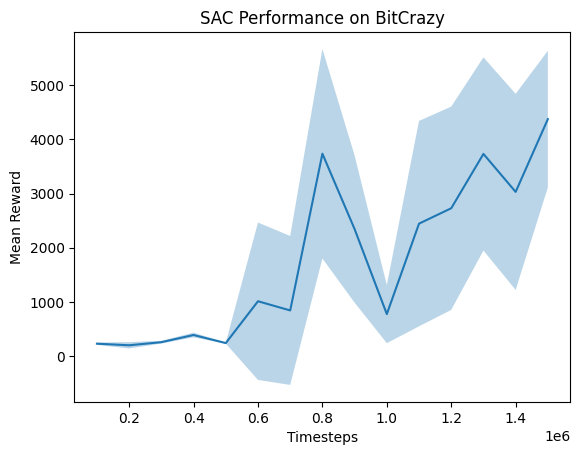

In [16]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()